Notebook for analysis of Maturation 72 (dose-response analysis of PD screening hits: 3 class LDA and phenotypic profile plots)

Imports

In [14]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics.pairwise import cosine_distances
from matplotlib import rcParams

Data loading

In [15]:
# Load data
df  = pd.read_csv('Exp72_DRC.csv')

# Define variable names
wt_dmso = 'WT;DMSO'
mut_dmso = 'Mut;DMSO'
mut_pro = 'Mut;PRO'
mut_cmpd = 'Mut;Compound'
compound_of_interest = 'Tyrphostin 9 ' #TIC10, Tyrphostin 9 
feature_to_plot = 'Cell_TH_SNCA_Intensity_SumIntensityPerNuclei_SNCA' # 'Cell_TH_SNCA_Intensity_SumIntensityPerNuclei_SNCA', Cell_Neurites_LengthPerNuclei_MAP2, Cell_Intensity_MeanIntensity_TH

# Plot style
# Set the seaborn style to "talk" and font to "Arial"
sns.set_context("talk")
rcParams['font.family'] = 'Arial'

display(df)

,Plate,Well,mahalanobis_from_neg,tags,SC_cat,SC_Batch,SC_name,SC_Target_name,final_conc,Destination Plate Barcode,...,Membrane_Intensity_MeanIntensity_TH,Membrane_Surface_SurfacePerNuclei_MAP2,Membrane_Surface_SurfacePerNuclei_SNCA,Nuclei_Living_Ratio_MAP2,Nuclei_Living_Ratio_MAP2_SNCA,Nuclei_Living_Ratio_SNCA,Nuclei_Living_Ratio_TH_SNCA,Nuclei_Ratio_Dead,Nuclei_Ratio_Living,Nuclei_Surface_MeanArea
0,PD-SCD-01,C03,1.662115,Mut;SNS-032,S1145,S1145-01,SNS-032,CDK,1.025641e-06,PD-SCD-01,...,-1.593747,-6.502860,12.845605,-12.811028,-9.625285,-0.374187,-2.284956,1.385739,-1.385738,-6.871544
1,PD-SCD-01,J15,1.962663,Mut;FCCP,S8276,S8276-01,FCCP,ATPase,5.128205e-07,PD-SCD-01,...,-1.682221,0.225100,6.011411,-2.389521,-1.755591,-0.400341,-1.117937,1.309715,-1.309713,-1.859936
2,PD-SCD-01,J16,23.753339,Mut;UNC2025,S7576,S7576-01,UNC2025,TAM Receptor#FLT3,3.025641e-05,PD-SCD-01,...,-6.730846,-12.814313,-2.997294,-80.579480,-72.484940,-61.607635,-24.145155,10.674232,-10.674224,-21.042257
3,PD-SCD-01,J17,6.602372,Mut;WAY-600,S2689,S2689-01,WAY-600,mTOR,1.025641e-05,PD-SCD-01,...,-3.733925,-0.420780,4.471941,-10.349825,-9.460428,-2.422203,-3.745358,1.134513,-1.134512,-2.976368
4,PD-SCD-01,J18,10.302262,Mut;GSK1324726A,S7620,S7620-01,GSK1324726A,Epigenetic Reader Domain,3.025641e-05,PD-SCD-01,...,2.695476,-1.999838,0.214094,-7.256453,-6.438302,-6.250929,-0.237847,2.205664,-2.205663,-4.749509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949,PD-SCD-04,G07,9.964745,Mut;Entinostat,S1053,S1053-01,Entinostat,HDAC,1.025641e-05,PD-SCD-04,...,5.541562,14.627384,9.565364,-5.165761,-3.843828,-2.728980,0.226159,3.427214,-3.427218,-5.366340
950,PD-SCD-04,G08,4.761684,Mut;Prostratin,PRO,PRO-01,Prostratin,PKC,3.012821e-05,PD-SCD-04,...,-0.850323,-3.545638,0.873264,-5.980204,-5.086194,-5.119943,-1.682617,0.661590,-0.661593,-4.994036
951,PD-SCD-04,G09,2.854845,Mut;Alectinib hydrochloride,S5232,S5232-01,Alectinib hydrochloride,ALK,5.025641e-06,PD-SCD-04,...,1.968873,0.062402,9.114964,-4.260637,-3.126252,-0.366511,-7.746156,-0.359901,0.359899,-3.653449
952,PD-SCD-04,H21,5.083136,Mut;Bimiralisib,S8738,S8738-01,Bimiralisib,PI3K,1.025641e-05,PD-SCD-04,...,0.089957,2.866629,3.025515,-11.185534,-7.151197,-1.072599,-1.134451,3.986073,-3.986076,-4.119987


Split data into compound and control data

In [16]:
# DATA WRANGLING

# Filter out Alectinib hydrochloride
mask = df['tags'].str.contains('Alectinib hydrochloride')
df = df.loc[~mask]

# NaN in concentration column correspond to "no treatment" and are filled with zero
df['final_conc'] = df['final_conc'].fillna(0)
df['final_conc'] = df['final_conc']*(10**6)
df = df.round({'final_conc': 2})

# Remove the "tags" column from the DataFrame to be plotted
print(df['final_conc'].unique())

# Add labels
df['exp_condition'] = np.where(df['tags'].isin([mut_dmso,wt_dmso,mut_pro]), df['tags'], mut_cmpd)
df['tags_conc'] = df['tags'] + ' ' + df['final_conc'].astype(str) + 'uM'

# SPLIT DATA

# Get only controls
df_ctrl = df[df['exp_condition'].str.contains('Mut;DMSO|WT;DMSO|Mut;PRO')]
# Get only Mut;DMSO controls
df_ctrl_mut = df[df['exp_condition'].str.contains(mut_dmso)]
# Get only compounds
df_cmpds = df[df['exp_condition'].str.contains(mut_cmpd)]
# Order alphabetically
df_cmpds = df_cmpds.sort_values(by='SC_name')

[ 1.03  0.51 30.26 10.26  5.13  0.    0.26  0.38  0.13 10.13 30.13]


Exclude toxic compounds

In [17]:
# Calculate DMSO medians per plate 
df_median = df_ctrl_mut.groupby(df_ctrl_mut['Plate']).median().reset_index().add_suffix('_median')
df_median = df_median.rename(columns={'Plate_median': "Plate"})

# Calculate DMSO SDs per plate 
df_std = df_ctrl_mut.groupby(df_ctrl_mut['Plate']).std().reset_index().add_suffix('_std')
df_std = df_std.rename(columns={'Plate_std': "Plate"})

# Merge median and std values
df_median_std = pd.merge(df_median[['Plate','Nuclei_Number_Living_median', 'Cell_Neurites_LengthPerNuclei_MAP2_median']],
                         df_std[['Plate','Nuclei_Number_Living_std', 'Cell_Neurites_LengthPerNuclei_MAP2_std']],
                         on='Plate', how='left')
# Join medians and SDs per plate with all data
df = df.join(df_median_std.set_index('Plate'), on='Plate')

# Thresholds for toxcity selection
SD_nuclei_thresh = 4

# Calculate toxicity limits
limit_nuclei = df['Nuclei_Number_Living_median']-SD_nuclei_thresh*df['Nuclei_Number_Living_std']

# Apply toxicity limits to dataset
df_thresholded = (df['Nuclei_Number_Living']>=limit_nuclei)
df = df.assign(non_toxic=df_thresholded)

# Select only non toxic molecules
df_non_toxic = df[df.non_toxic]

# Clean dataframe
cols_to_drop = ['Nuclei_Number_Living_median', 
                 'Cell_Neurites_LengthPerNuclei_MAP2_median', 
                 'Nuclei_Number_Living_std', 
                 'Cell_Neurites_LengthPerNuclei_MAP2_std']

df_non_toxic = df_non_toxic.drop(columns=cols_to_drop)

C:\Users\JohannesWilbertz\AppData\Local\Temp\ipykernel_13720\2987270621.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_median = df_ctrl_mut.groupby(df_ctrl_mut['Plate']).median().reset_index().add_suffix('_median')
C:\Users\JohannesWilbertz\AppData\Local\Temp\ipykernel_13720\2987270621.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_std = df_ctrl_mut.groupby(df_ctrl_mut['Plate']).std().reset_index().add_suffix('_std')


Split non-toxic data into compound and control data

In [18]:
# Get only controls
df_non_toxic_ctrl = df_non_toxic[df_non_toxic['exp_condition'].str.contains('Mut;DMSO|WT;DMSO|Mut;PRO')]
# Get only Mut;DMSO controls
df_non_toxic_ctrl_mut = df_non_toxic[df_non_toxic['exp_condition'].str.contains(mut_dmso)]
# Get only compounds
df_non_toxic_cmpds = df_non_toxic[df_non_toxic['exp_condition'].str.contains(mut_cmpd)]
# Order alphabetically
df_non_toxic_cmpds = df_non_toxic_cmpds.sort_values(by='SC_name')

Hit selection

In [19]:
# Choose hits based on threshold
hit_selection_thresh = 3
df_pre_hits = df_non_toxic_ctrl.loc[df_non_toxic_ctrl['mahalanobis_from_neg'] > hit_selection_thresh]

# Drop all tags that occur only once
df_hits = df_pre_hits[df_pre_hits.duplicated(subset=['tags'], keep=False)]
df_hits_grouped = df_hits.groupby(['tags'], as_index=False).mean()

C:\Users\JohannesWilbertz\AppData\Local\Temp\ipykernel_13720\2075259382.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_hits_grouped = df_hits.groupby(['tags'], as_index=False).mean()


Plot control columns per plate for quality inspection

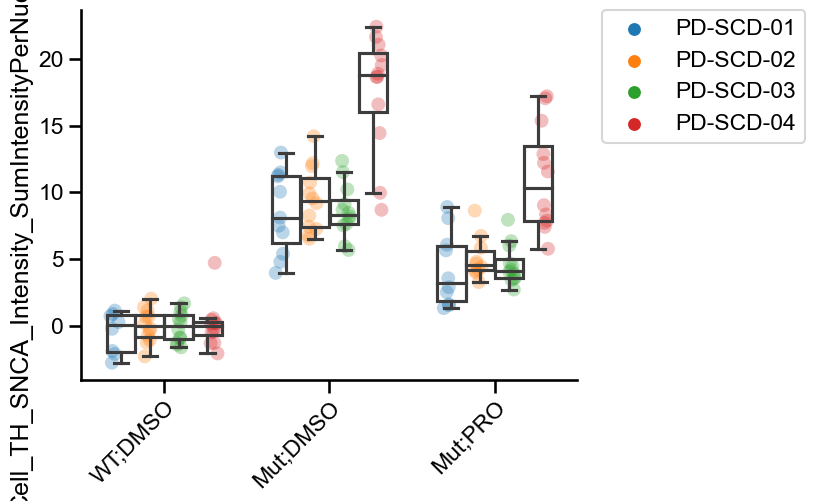

In [20]:
# What to plot?
data = df_non_toxic_ctrl
df_non_toxic_ctrl_cols = df_non_toxic_ctrl.columns.to_list()
x = 'tags'
hue = "Plate"
y = feature_to_plot 
ytitle = y
order = [wt_dmso, mut_dmso, mut_pro]

sns.set_context('talk') # font_scale=1.5

# Boxplot
ax = sns.boxplot(x=x, y=y, data=data, width=0.7, 
                         showfliers=False, hue=hue, order=order, zorder=1) 
# Transparancy of boxplot filling color
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0))

# Striplot overlaid on transparent boxplot
ax = sns.stripplot(x=x, y=y, data=data, size=10, alpha=0.3, 
                           zorder=0, hue=hue, order=order, dodge=True)
        
# Remove first rows from legend and move it
h,l = ax.get_legend_handles_labels()
plt.legend(h[4:8],l[4:8],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# Figure aesthetics
ax.set(xlabel=None)
ax.set(ylabel=y)
sns.despine()
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right', rotation_mode="anchor")

# Save plot
plt.savefig('Controls_' + y + '.pdf', bbox_inches='tight')
plt.show()

Plot dose-response graphs for one feature, for all compounds

In [21]:
# Define the filename
filename = 'DRC_' + 'AllCompounds_' + y + '.pdf'

# Check if the file does not exist
if not os.path.isfile(filename):

    # What to plot?
    data = df_non_toxic_cmpds
    y = feature_to_plot
    x = "final_conc"
    plot_col = 'SC_name'
    xtitle = 'Concentration (uM)'
    ytitle = y

    sns.set_context('talk', font_scale=1.5)

    # lmplot
    g = sns.lmplot(data=data, x=x, y=y, 
                    line_kws={'color': 'black'},
                    scatter_kws={'color': 'black'}, 
                    col=plot_col,
                    col_wrap=7,
                    sharey=False)

    # Adjust the scale & ticks
    g.set(xscale="log")
    g.set(ylim=(None, None))
    # Adjust titles
    g.set_titles("{col_name}")
    # Adjust axis labels
    g.set_axis_labels(xtitle, ytitle)

    # Save plot
    plt.savefig(filename, bbox_inches='tight')
    plt.show()


Plot dose-response graph for one feature, for only single compound of interest

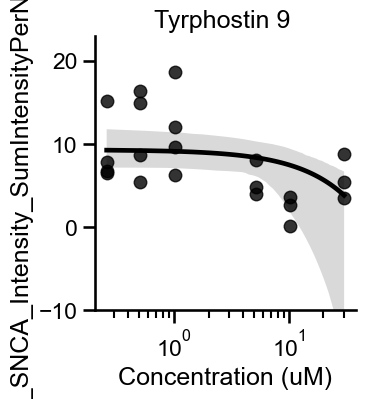

In [22]:
# What to plot?
compound_of_interest = compound_of_interest
data = df_non_toxic_cmpds
y = feature_to_plot
x = "final_conc"
xtitle = 'Concentration (uM)'
ytitle = y

sns.set_context('talk')

# Extract only compound of interest
data = data[data['SC_name'].str.contains(compound_of_interest)]

# lmplot
g = sns.lmplot(data=data, x=x, y=y, aspect=1, height=4,
                line_kws={'color': 'black'},
                scatter_kws={'color': 'black'})

# Adjust the scale & ticks
g.set(xscale="log")
g.set(ylim=(-10, 23))
# Adjust axis labels
g.set_axis_labels(xtitle, ytitle)
# Adjust titles
g2 = plt.gca()
g2.set_title(compound_of_interest)

# Save plot
plt.savefig('DRC_' + compound_of_interest + '_' + y + '.pdf', bbox_inches='tight')
plt.show()

Plot Mahalanobis distances for all compounds

In [23]:
# Define the filename
filename = 'MahalanobisDistance_AllCompounds' + '.pdf'

# Check if the file does not exist
if not os.path.isfile(filename):

    # What to plot?
    data = df_non_toxic_cmpds
    plot_col = 'SC_name'

    # Set colors
    color_dict = dict({wt_dmso:'#4C72B0',
                      mut_cmpd:'gray',
                      mut_dmso:'#C44E52',
                      mut_pro: 'orange',
                      compound_of_interest: 'black'})

    # Plot a new scatter plot in which the compound of interest marker size depends on the concentration
    g = sns.relplot(data=data, x='mahalanobis_from_neg', y='mahalanobis_from_pos', 
                    col = plot_col, 
                    hue='exp_condition', 
                    size='final_conc', 
                    sizes=(30, 400), alpha=.5, palette=color_dict, 
                    legend='full',
                    col_wrap=7, aspect=1)

    # Draw lines to indicate reference groups
    g.map(plt.axvline, x=4, ls='--', c='red')
    g.map(plt.axhline, y=5, ls='--', c='blue')
    # Adjust titles
    g.set_titles("{col_name}")

    # Save plot
    plt.savefig(filename, bbox_inches='tight')
    plt.show()


Plot Mahalanobis distances for single compound

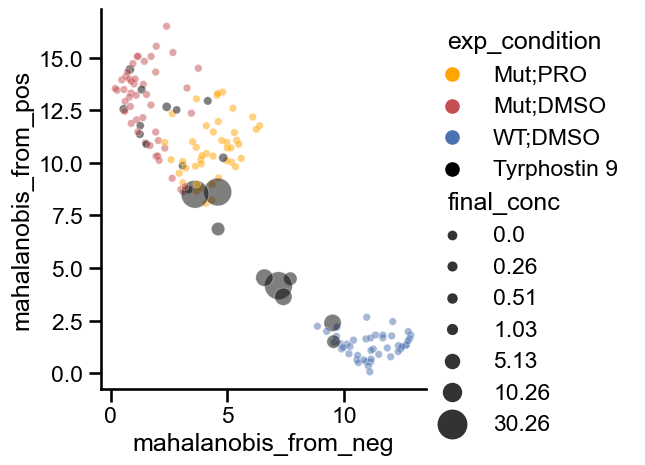

In [24]:
# What to plot?
data = df_non_toxic
compound_of_interest = compound_of_interest

# Delete all compounds except compound of interest
data['exp_condition'] = np.where((data.SC_name == compound_of_interest),compound_of_interest,data.exp_condition)
data_cmpd = data[~data['exp_condition'].str.contains(mut_cmpd)]

sns.set_context("talk")

# Set colors
color_dict = dict({wt_dmso:'#4C72B0',
                  mut_cmpd:'gray',
                  mut_dmso:'#C44E52',
                  mut_pro: 'orange',
                  compound_of_interest: 'black'})

hue_order=[wt_dmso, mut_pro, mut_cmpd, mut_dmso, compound_of_interest]

# Plot a new scatter plot in which the compound of interest marker size depends on the concentration
g = sns.relplot(data=data_cmpd, 
                x='mahalanobis_from_neg', 
                y='mahalanobis_from_pos', 
                hue='exp_condition', 
                size='final_conc', 
                sizes=(30, 400), 
                alpha=.5, 
                palette=color_dict, 
                legend='full',
                aspect=1)

# Save plot
plt.savefig('MahalanobisDistance_' + compound_of_interest + '.pdf', bbox_inches='tight')
plt.show()

In [25]:
# Data
data = data_cmpd

# Assuming 'data' is your DataFrame and 'tags_conc' is your column
substrings = ['0.0', ' 0.26', '0.51', '5.13'] #, ' 0.26', '1.03', '5.13'

# Create a boolean mask
mask = data['tags_conc'].str.contains('|'.join(substrings))

# Apply the mask to the DataFrame
data = data[mask]

Lineplot representation of phenotypic profiles

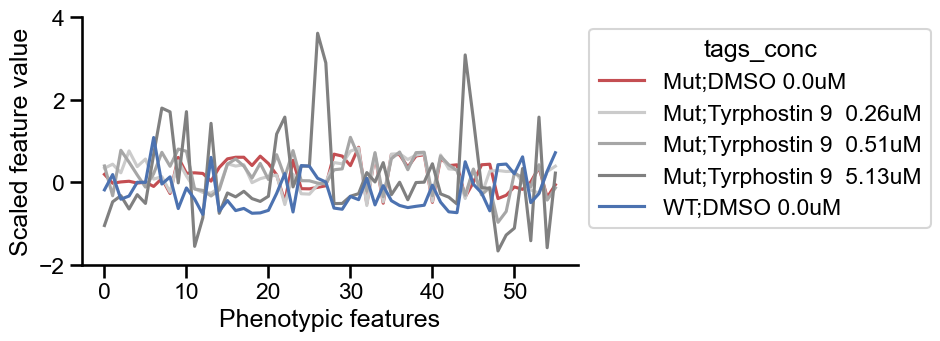

In [26]:
# Data
data = data_cmpd

# Assuming 'data' is your DataFrame and 'tags_conc' is your column
substrings = ['0.0', ' 0.26', '0.51', '5.13'] #, ' 0.26', '1.03', '5.13'

# Create a boolean mask
mask = data['tags_conc'].str.contains('|'.join(substrings))

# Apply the mask to the DataFrame
data = data[mask]

# Define your specific colors
color_dict = {'WT;DMSO 0.0uM': '#4C72B0', 'Mut;DMSO 0.0uM': '#C44E52'}

# Get the unique tags from data['tags_conc']
tags = sorted(set(data['tags_conc']))

# Remove the specific tags from the list
tags = [tag for tag in tags if tag not in color_dict.keys()]

# Generate a colormap in seaborn
cmap = sns.light_palette("gray", len(tags))

# Assign colors to the rest of the tags
for tag, color in zip(tags, cmap):
    color_dict[tag] = matplotlib.colors.rgb2hex(color)

sns.set_context("talk")
    
# Sort columns alphabetically
data = data.sort_index(axis=1)

# Select only the numeric columns and keep the 'tags' column
numeric_cols = data.select_dtypes(include=np.number).columns.tolist() + ['tags_conc']

# Substract all numeric and specified categorical columns from all columns to prevent them from being dropped
cols_to_drop = data.columns.difference(numeric_cols).tolist()

# Drop defined set of colums
data = data.drop(columns=list(cols_to_drop))

# Drop a number of not required numeric columns
cols_to_drop2 = ['final_conc', 
                'mahalanobis_from_neg', 
                'mahalanobis_from_pos']

# Drop defined second set of colums
data = data.drop(cols_to_drop2, axis=1)

# Select numerical cols
data_numeric = data.select_dtypes(include=np.number)

# Scale the data
# Create an instance of the scaler
scaler = RobustScaler()
# Fit the scaler to the data and transform it
data_scaled = pd.DataFrame(scaler.fit_transform(data_numeric), columns=data_numeric.columns)

# Add the "tags" column back to the scaled data
data_scaled = data_scaled.assign(tags_conc=data.tags_conc.values)

# Remove the rows that contain "Mut;PRO" in the "tags" column
data_scaled = data_scaled.loc[~data_scaled['tags_conc'].str.contains(mut_pro)]

# Group columns based on tags and calculate median
data_scaled_median = data_scaled.groupby(["tags_conc"], as_index=False).median()

# Convert dataframe to long (tidy) form
dfm = data_scaled_median.melt('tags_conc', var_name='cols', value_name='vals')

# Melt the dataframe to have columns as a variable
data_melted = data_scaled_median.melt(id_vars='tags_conc', var_name='features', value_name='values')

# Convert feature names to numbers
data_melted['features'] = data_melted['features'].astype('category')
data_melted['features'] = data_melted['features'].cat.codes

# Create the line plot
ax = sns.lineplot(data=data_melted, x='features', y='values', hue='tags_conc', palette=color_dict) 

# Figure aesthetics
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.despine()
ax.set_box_aspect(0.5)
ax.set_ylabel('Scaled feature value')
ax.set_xlabel('Phenotypic features')
ax.set_ylim(-2, 4)

# Save plot
plt.savefig(f'PhenoProfile_LineMap_{compound_of_interest}.pdf', bbox_inches='tight')
plt.show()

Prepare data for Cosine distance DRC

In [27]:
data_cmpd_copy = data_cmpd.copy()

# Remove the numeric columns: 'index', 'mahalanobis_from_pos', 'mahalanobis_from_neg'
numeric_cols_to_remove = ['mahalanobis_from_pos', 'mahalanobis_from_neg']
data_cmpd_copy = data_cmpd_copy.drop(columns=numeric_cols_to_remove)

# Scale all numeric columns
numeric_cols = data_cmpd_copy.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove 'final_conc' from numeric_cols
if 'final_conc' in numeric_cols:
    numeric_cols.remove('final_conc')

scaler = RobustScaler()
data_cmpd_copy[numeric_cols] = scaler.fit_transform(data_cmpd_copy[numeric_cols])

# Keep only certain categories
tags_to_keep = ['Mut;' + compound_of_interest, 'WT;DMSO', 'Mut;DMSO']
data_cmpd_copy = data_cmpd_copy[data_cmpd_copy['tags'].isin(tags_to_keep)]

data_cmpd_copy

,Plate,Well,tags,SC_cat,SC_Batch,SC_name,SC_Target_name,final_conc,Destination Plate Barcode,Nuclei_Number_Living,...,Nuclei_Living_Ratio_MAP2,Nuclei_Living_Ratio_MAP2_SNCA,Nuclei_Living_Ratio_SNCA,Nuclei_Living_Ratio_TH_SNCA,Nuclei_Ratio_Dead,Nuclei_Ratio_Living,Nuclei_Surface_MeanArea,exp_condition,tags_conc,non_toxic
19,PD-SCD-01,K13,Mut;DMSO,NaN,NaN,NaN,NaN,0.00,NaN,0.183351,...,-0.614946,-0.538343,-0.434550,-0.846737,0.606889,-0.606887,-0.203315,Mut;DMSO,Mut;DMSO 0.0uM,True
20,PD-SCD-01,K14,WT;DMSO,NaN,NaN,NaN,NaN,0.00,NaN,-0.410959,...,0.211942,0.292223,0.837935,0.694246,0.123358,-0.123357,0.765423,WT;DMSO,WT;DMSO 0.0uM,True
29,PD-SCD-01,J13,Mut;DMSO,NaN,NaN,NaN,NaN,0.00,NaN,0.587987,...,0.218409,0.217600,0.758631,-0.134296,-0.066664,0.066664,0.035255,Mut;DMSO,Mut;DMSO 0.0uM,True
39,PD-SCD-01,I13,Mut;DMSO,NaN,NaN,NaN,NaN,0.00,NaN,0.583772,...,-0.605466,-0.584725,0.378109,-0.184617,0.621025,-0.621023,0.180097,Mut;DMSO,Mut;DMSO 0.0uM,True
50,PD-SCD-01,J04,Mut;Tyrphostin 9,S2895,S2895-01,Tyrphostin 9,PDGFR#EGFR,0.51,PD-SCD-01,0.082192,...,-1.226236,-1.134637,0.508339,-0.103934,0.363800,-0.363799,-0.028341,Tyrphostin 9,Mut;Tyrphostin 9 0.51uM,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,PD-SCD-04,G13,Mut;DMSO,NaN,NaN,NaN,NaN,0.00,NaN,-1.203372,...,-0.870145,-0.804491,-1.278831,0.821631,1.417583,-1.417584,-0.691320,Mut;DMSO,Mut;DMSO 0.0uM,True
914,PD-SCD-04,H13,Mut;DMSO,NaN,NaN,NaN,NaN,0.00,NaN,0.208641,...,-0.550293,-0.380388,-1.724739,-0.218976,0.119476,-0.119476,0.046879,Mut;DMSO,Mut;DMSO 0.0uM,True
915,PD-SCD-04,H14,WT;DMSO,NaN,NaN,NaN,NaN,0.00,NaN,-0.596417,...,0.576863,0.490751,1.131320,0.634142,-0.623929,0.623928,0.569141,WT;DMSO,WT;DMSO 0.0uM,True
935,PD-SCD-04,F13,Mut;DMSO,NaN,NaN,NaN,NaN,0.00,NaN,0.507903,...,-0.370172,-0.379096,-1.275312,0.168576,0.199067,-0.199068,-0.084344,Mut;DMSO,Mut;DMSO 0.0uM,True


Plot Cosine distance DRC

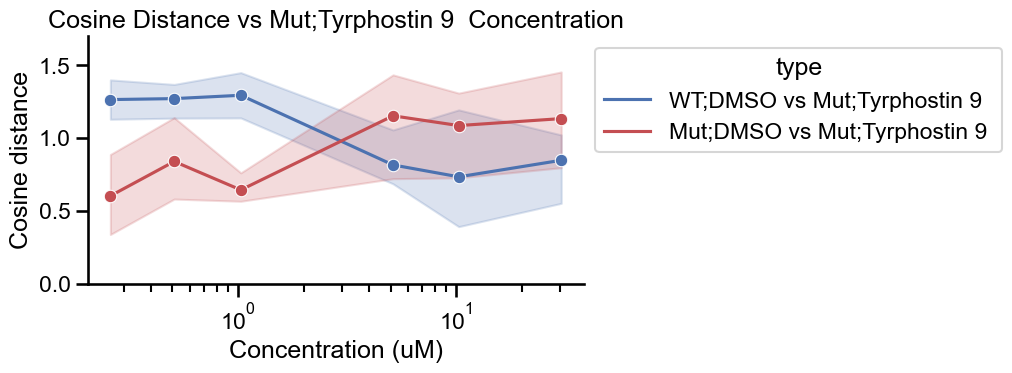

In [28]:
# Filter data for the three categories
data_DMSO_WT = data_cmpd_copy[data_cmpd_copy['tags'] == 'WT;DMSO'][numeric_cols]
data_DMSO_Mut = data_cmpd_copy[data_cmpd_copy['tags'] == 'Mut;DMSO'][numeric_cols]
data_compound_of_interest = data_cmpd_copy[data_cmpd_copy['tags'] == 'Mut;' + compound_of_interest][numeric_cols]

# Calculate Cosine distance
cos_dist_1 = cosine_distances(data_DMSO_WT, data_compound_of_interest)
cos_dist_2 = cosine_distances(data_DMSO_Mut, data_compound_of_interest)

# Create a new DataFrame for plotting
plot_data_1 = pd.DataFrame({
    'final_conc': data_cmpd_copy[data_cmpd_copy['tags'] == 'Mut;' + compound_of_interest]['final_conc'],
    'cosine_dist': cos_dist_1.diagonal(),  # get the diagonal elements which represent the Cosine distance between pairs
    'type': 'WT;DMSO vs Mut;' + compound_of_interest
}).reset_index(drop=True)

plot_data_2 = pd.DataFrame({
    'final_conc': data_cmpd_copy[data_cmpd_copy['tags'] == 'Mut;' + compound_of_interest]['final_conc'],
    'cosine_dist': cos_dist_2.diagonal(),  # get the diagonal elements which represent the Cosine distance between pairs
    'type': 'Mut;DMSO vs Mut;' + compound_of_interest
}).reset_index(drop=True)

# Concatenate the two dataframes
plot_data = pd.concat([plot_data_1, plot_data_2]).reset_index(drop=True)

# Plot using seaborn

color_dict = dict({'WT;DMSO vs Mut;' + compound_of_interest:'#4C72B0',
                  'Mut;DMSO vs Mut;' + compound_of_interest:'#C44E52'})

ax = sns.lineplot(data=plot_data, x='final_conc', y='cosine_dist', hue='type',
    marker="o", dashes=False, palette=color_dict)

# Figure aesthetics
plt.title('Cosine Distance vs Mut;{} Concentration'.format(compound_of_interest))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.despine()
ax.set(xscale="log")
ax.set_ylim([0, 1.7])
ax.set_box_aspect(0.5)
ax.set_ylabel('Cosine distance')
ax.set_xlabel('Concentration (uM)')

# Save plot
plt.savefig('CosineDistances' + compound_of_interest + '.pdf', bbox_inches='tight')
plt.show()


Make sure the added final_conc column in data_scale has no unwanted effects on downstream plots

Preparation of data for cluster-heatmap plotting

In [29]:
# Which data to use?
data = df_non_toxic
compound_of_interest = compound_of_interest

# Sort columns alphabetically
data = data.sort_index(axis=1)

# Remove the rows that contain the positive "Mut;PRO" in the "tags" column
data = data.loc[~data['tags'].str.contains(mut_pro)]

# Replace all occurrences of compound_of_interest with mut_cmpd
data['exp_condition'] = data['exp_condition'].str.replace(compound_of_interest, mut_cmpd)

# Select concentrations of interest
data_conc = data[data['final_conc'].isin([5.13, 0])] # 0.26

# Scale numeric data
data_conc_numeric = data_conc.select_dtypes(include=np.number).drop(columns=['final_conc', 'mahalanobis_from_neg', 'mahalanobis_from_pos']) 
scaler = RobustScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_conc_numeric), columns=data_conc_numeric.columns)


Clustermap representation of all compound and control phenotypic profiles

c:\Users\JohannesWilbertz\anaconda3\envs\tools\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


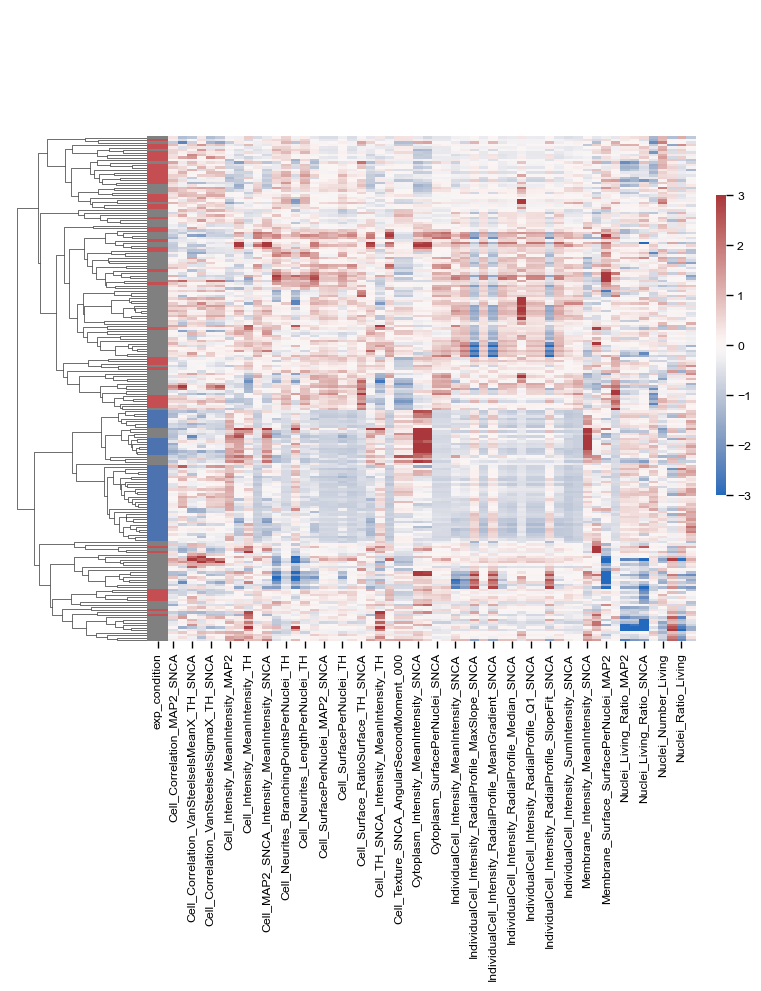

In [30]:
# Add the "exp_condition" column back to the scaled data
data_scaled = data_scaled.assign(exp_condition=data_conc.exp_condition.values) #tags_conc=data_conc.tags_conc.values

# Define the color map to be used for the "tags" column
row_colors = data_scaled["exp_condition"].map({wt_dmso:'#4C72B0', 
                                               mut_dmso:'#C44E52',
                                               mut_cmpd: 'gray'})

data_scaled = data_scaled.drop(columns = ["exp_condition"])

# Plot clustermap
sns.set_context('paper')
g = sns.clustermap(data_scaled,
                    metric='cosine',
                    col_cluster=False,
                    cmap = "vlag",
                    row_colors = row_colors,
                    yticklabels=False,
                    vmin =-3, vmax=3)

# Move and adjust legend
g.fig.subplots_adjust(right=0.7)
g.ax_cbar.set_position((0.72, .5, .01, .3))

# Save plot
plt.savefig('PhenoProfile_ClusterMap_All_Compounds' + compound_of_interest + '.pdf', bbox_inches='tight')
plt.show()

Clustermap representation of the means of all compound and control phenotypic profiles

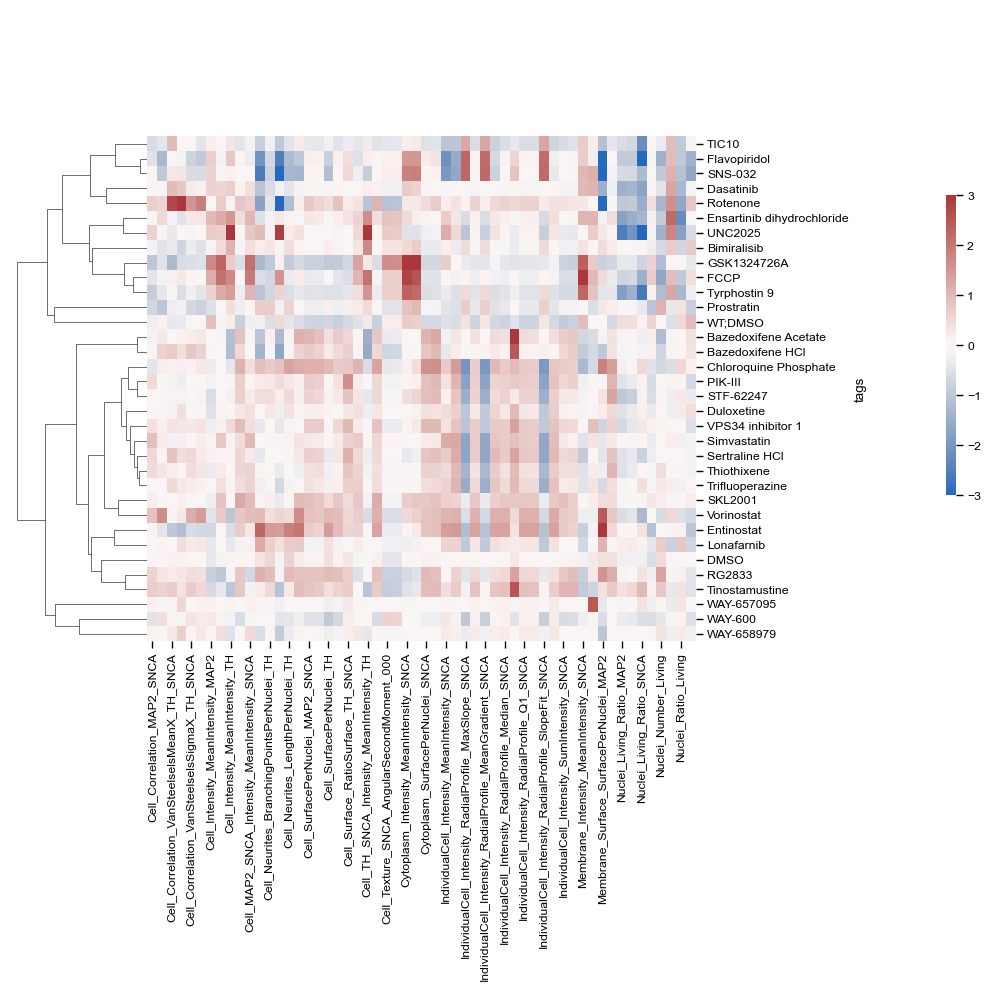

In [31]:
# Add the "tags" column back to the scaled data
data_scaled = data_scaled.assign(tags=data_conc.tags.values)

data_scaled['tags'] = data_scaled['tags'].str.replace('Mut;', '')

# Group data by "tags" and calculate mean
data_scaled = data_scaled.groupby(['tags'], as_index=True).mean()

# Plot clustermap
sns.set_context('paper')
g = sns.clustermap(data_scaled,
                    metric='cosine',
                    col_cluster=False,
                    cmap = "vlag",
                    yticklabels=True,
                    vmin =-3, vmax=3)

# Move and adjust legend
g.fig.subplots_adjust(right=0.7)
g.ax_cbar.set_position((0.95, .5, .01, .3))

# Save plot
plt.savefig('PhenoProfile_ClusterMap_All_Compounds_mean' + '.pdf', bbox_inches='tight')
plt.show()

JUMP-CP data: Clustermap representation of the means of all compound and control phenotypic profiles

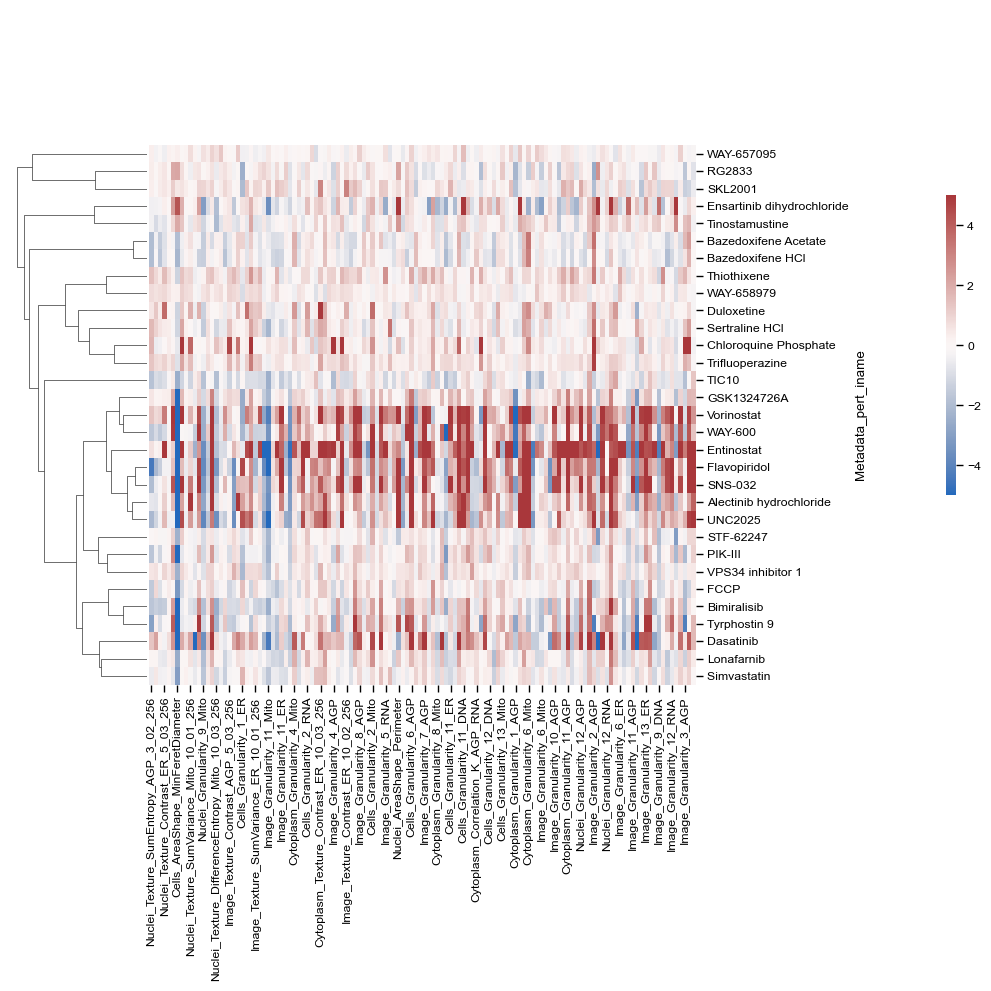

In [32]:
source_name="source_7_25"
list_hit = ['WAY-657095', 'WAY-658979', 'Dasatinib', 'STF-62247', 
            'Vorinostat', 'Entinostat', 'SNS-032', 'Flavopiridol', 
            'Simvastatin ', 'Bazedoxifene HCl', 'Bazedoxifene Acetate',
            'WAY-600', 'Lonafarnib', 'Tyrphostin 9 ', 'Ensartinib dihydrochloride',
            'Sertraline HCl', 'Chloroquine Phosphate', 'Duloxetine', 'Alectinib hydrochloride', 
            'Trifluoperazine', 'RG2833', 'UNC2025', 'GSK1324726A', 'PIK-III', 'TIC10', 'FCCP',
            'SKL2001', 'VPS34 inhibitor 1', 'Bimiralisib', 'Tinostamustine', 'Thiothixene']

# Cleaned & normalized dataframe containing all compounds
df_norm = pd.read_feather(f"L:/PROJECTS/JUMP-CP/jumpAWS/concatSources/profiles/{source_name}_feature_select.fth")

# Cleaned & normalized dataframe containing hit compounds only
# Not all compounds in list_hit are present because not all fullfilled QC criteria in JUMP-CP data
df_hit_jump=df_norm[df_norm['Metadata_pert_iname'].isin(list_hit)].reset_index(drop=True)

# Filter the columns based on regular expression
regex = "^Metadata_(?!pert_iname)"
cols_to_drop = df_hit_jump.filter(regex=regex).columns

# Drop the filtered columns
df_hit_jump.drop(cols_to_drop, axis=1, inplace=True)

data = df_hit_jump

# Group data by "tags" and calculate mean
data = data.groupby(['Metadata_pert_iname'], as_index=True).mean()

# Plot clustermap
sns.set_context('paper')
g = sns.clustermap(data, metric='cosine', 
                   col_cluster=False, 
                   cmap = "vlag", 
                   yticklabels=True, 
                   vmin =-5, vmax=5)

# Move and adjust legend
g.fig.subplots_adjust(right=0.7)
g.ax_cbar.set_position((0.95, .5, .01, .3))

# Save plot
plt.savefig('JUMP-CP_PhenoProfile_ClusterMap_All_Compounds_mean' + '.pdf', bbox_inches='tight')
plt.show()